
# Perform Customer Clustering based on user portrait and corresponding transactions


In [136]:
# -*- coding: utf-8 -*-

import sys, getopt
import pandas as pd
import datetime
import os
import Tkinter, tkFileDialog
import numpy as np

# input path
pathInp_data = "/Users/ito/venv/CG-RecoEng/data/"
# set the working directory
os.chdir(pathInp_data)

## Data Wrangling

In [163]:
NOW = datetime.date.today()
inputfile = '/Users/ito/venv/CG-RecoEng/data/og_data/Sales_Transaction.csv'
orders = pd.read_csv(inputfile, sep=',', engine='c', parse_dates=['TransactionDate'])
print "The fields present in the input data set are:"
print orders.columns

The fields present in the input data set are:
Index([u'TypeGroup', u'BUID', u'BranchID', u'TransactionDate', u'CustomerID',
       u'CardNo', u'TicketNumber', u'SKUCode', u'Spending', u'DeptCode',
       u'SubDeptCode', u'QTY'],
      dtype='object')


In [164]:
orders.head(2)

,TypeGroup,BUID,BranchID,TransactionDate,CustomerID,CardNo,TicketNumber,SKUCode,Spending,DeptCode,SubDeptCode,QTY
0,1,1,175,2017-01-04 18:53:00,B794153F-943C-4181-A73D-22899BEC5DED,8041474156,404089732,4423513,350.0,600.0,601.0,1
1,1,1,5,2017-01-08 12:49:00,7451F1CB-4686-4D5F-8CB3-9E747B575A6F,8013455916,211318750,3415920,1473.0,200.0,205.0,1


From the discussion with Joc, we fix Tops data as the data for the demo.

Reason is because that in the data "ProductMaster_Tops.csv" that given to us, all the products are in details rather than category info -- which is good for our analysis (e.g., item of interest, item of recommendation).


In [143]:
productfile = '/Users/ito/venv/CG-RecoEng/data/og_data/ProductMaster_Tops.csv'
product = pd.read_csv(productfile, sep=',', engine='c')

In [144]:
product.head(2)

,BUID,SKUID,PRODUCT_ENG_DESC,DEPT_ID,DEPT_ENG_DESC,SUBDEPT_ID,SUBDEPT_ENG_DESC,CLASS_ID,CLASS_ENG_DESC,CAT_ID,CAT_ENG_DESC,SUBCAT_ID,SUBCAT_ENG_DESC,BRAND_CODE,BRAND_ENG_NAME,SUPPLIER_CODE,SUPPLIER_ENG_NAME
0,150,8851984131769,Autoquip Takara Springe(C2,3,GM/Housewares,5,GM/Non FMCG,1,DIY/Non FMCG,2,Garden Accessories/Non FMCG,1,Gardening Tools,10703,AUTO QUIP,9811566,"AUTO QUIP LTD.,PART"
1,150,8851984131837,Autoquip Takara Roll Jasmin(C2,3,GM/Housewares,5,GM/Non FMCG,1,DIY/Non FMCG,2,Garden Accessories/Non FMCG,1,Gardening Tools,10703,AUTO QUIP,9811566,"AUTO QUIP LTD.,PART"


Hence, we set Tops_trans_df as the data frame of the grocery data for the demo.

In [145]:
# Data Segmentation for Tops
Tops_trans_df = orders[orders.SKUCode.isin(product.SKUID)]
print len(Tops_trans_df.SKUCode)
print len(Tops_trans_df.SKUCode.drop_duplicates())

1995491
44057


Means that, for Tops supermarket, among 1995491 times of product purchasing, there are 44057 kinds of unique items.


In [146]:
Tops_trans_df.head(2)

,TypeGroup,BUID,BranchID,TransactionDate,CustomerID,CardNo,TicketNumber,SKUCode,Spending,DeptCode,SubDeptCode,QTY
7360,1,150,4294,2017-02-27 20:12:00,312CB58B-09B6-49CA-9F1D-AEF8D56E3F4E,8035450104,40155510,8851954101211,17.00,1.0,3.0,1
7361,1,150,2865,2017-01-18 12:28:00,35FFAE65-80FA-4A2B-8F05-98ACAE82EF86,8028520371,80176812,8851717901607,100.39,1.0,4.0,2


In [147]:
cstmfile = '/Users/ito/venv/CG-RecoEng//data/og_data/Customer_Profile.csv'
customer = pd.read_csv(cstmfile, sep=',', engine='c')

def strip_brace(input):
#     input = input.strip('{')
#     input = input.strip('}')
    return input[1:-1]
#     return input

customer.CustomerID = customer.CustomerID.map(strip_brace)

In [148]:
grouped_by_userID = Tops_trans_df.groupby('CustomerID')

In [149]:
10000 - grouped_by_userID.__len__()

796

Means that, there are 10000 - 9204 = 796 customers who never go to Tops until now.

Below we calculate the portrait for each customer.

## Calculation for the fields in the user portrait

In [150]:
Tops_trans_df['tDate2'] = pd.to_datetime(Tops_trans_df['TransactionDate']).dt.date
recency = grouped_by_userID.tDate2.agg({'recency': lambda x: (NOW - x.max()).days})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [151]:
spent = grouped_by_userID.Spending.agg({'total_spent': np.sum, 'avg_spent': np.mean, 'med_spent': np.median})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [152]:
frequency = grouped_by_userID.TicketNumber.agg({'frequency': lambda x: len(x)})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [153]:
spent_range = grouped_by_userID.Spending.agg({'spent_range': lambda x: x.max()- x.min()})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [154]:
quantities = grouped_by_userID.QTY.agg({'quantities': np.sum})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [155]:
from collections import Counter 
varieties = grouped_by_userID.SKUCode.agg({'varieties': lambda x: len(Counter(x))})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [156]:
valid = grouped_by_userID.Spending.agg({'valid_trans': np.count_nonzero})
refund = grouped_by_userID.Spending.agg({'refund': lambda x: len(x[x<0])})
# Counter(Tops_trans_df.Spending<0)[True]

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [157]:
portrait_df = pd.concat([recency, spent, spent_range, quantities, varieties, frequency, valid, refund],join="inner",axis=1)
portrait_df.head(3)

,recency,total_spent,avg_spent,med_spent,spent_range,quantities,varieties,frequency,valid_trans,refund
CustomerID,,,,,,,,,,
0003B311-AEFF-494D-9AAD-9951FA5AC599,169,16554.28,88.054681,46.775,1677.05,217,160,188,184.0,1.0
0005861F-87C4-4CEB-80D4-61CFB8F34E47,173,3458.70,111.570968,76.000,340.00,33,30,31,31.0,0.0
000684B2-425D-4B3E-9F97-388B88C2A2AD,155,11432.30,178.629688,101.500,856.00,139,54,64,61.0,0.0


In [158]:
# Index([u'TypeGroup', u'BUID', u'BranchID', u'TransactionDate', u'CustomerID',
#        u'CardNo', u'TicketNumber', u'SKUCode', u'Spending', u'DeptCode',
#        u'SubDeptCode', u'QTY'],
#       dtype='object')
Tops_trans_df.head(2)

,TypeGroup,BUID,BranchID,TransactionDate,CustomerID,CardNo,TicketNumber,SKUCode,Spending,DeptCode,SubDeptCode,QTY,tDate2
7360,1,150,4294,2017-02-27 20:12:00,312CB58B-09B6-49CA-9F1D-AEF8D56E3F4E,8035450104,40155510,8851954101211,17.00,1.0,3.0,1,2017-02-27
7361,1,150,2865,2017-01-18 12:28:00,35FFAE65-80FA-4A2B-8F05-98ACAE82EF86,8028520371,80176812,8851717901607,100.39,1.0,4.0,2,2017-01-18


## Customer Clustering
Data Normalization before training process.

In [165]:
from sklearn.preprocessing import normalize

print
X = np.array(portrait_df)
normed_X = normalize(X, axis=0, norm='l1')
X = normed_X

Suggested by Joc, hereby an elbow method for #cluster selection is conducted. Firstly, initialize the plot env.

In [166]:
import matplotlib.pyplot as plt
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

Perform k-means while tracking their avg clustering distortions.

The “elkan” variation is more efficient by using the triangle inequality.
And it doesn’t support sparse data -- which is good -- our data is dense :)

In [176]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, algorithm='elkan',init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

Plot the elbow according to the distortions from k-means.

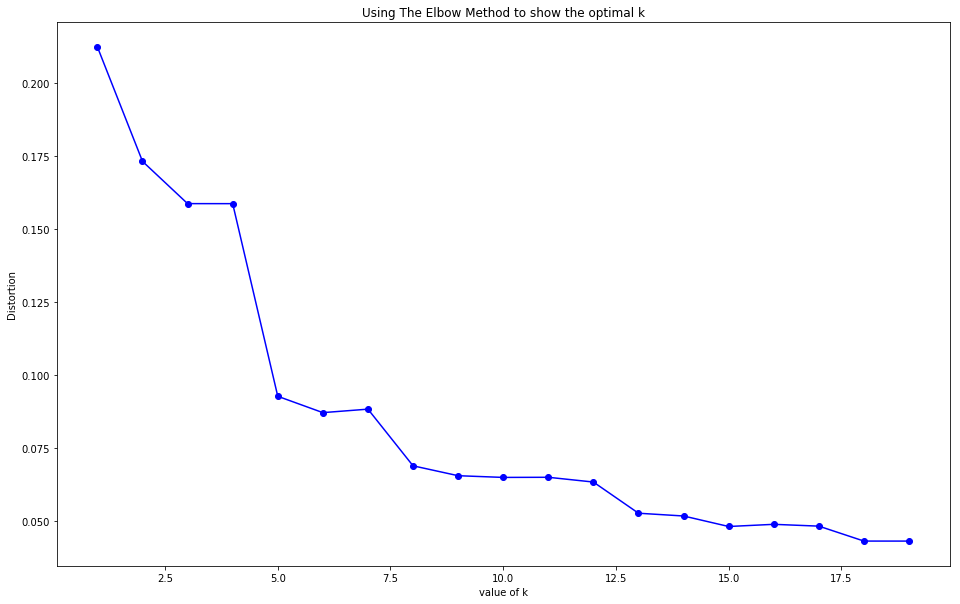

In [177]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('value of k')
plt.ylabel('Distortion')
plt.title('Using The Elbow Method to show the optimal k')
plt.gcf().set_size_inches(16, 10)
plt.show()

At this stage, I would rather choose k = 5 for k, since 5, 6, 7.. share similar performance. Hence let's proceed to analyse when k = 5. 

Also we care about when k = 8.

## Clusters Analysis

In [193]:
kmeanModelfinal = KMeans(n_clusters=5, algorithm='elkan').fit(X)

See the number of customers in each cluster.

In [232]:
clusters = kmeanModelfinal.labels_.tolist()
clusters_dic = Counter(clusters)
pie_vec = [clusters_dic[i] for i in range(5)]
print pie_vec

[7799, 7, 25, 118, 1255]


A pie chart plot to visualize the %.

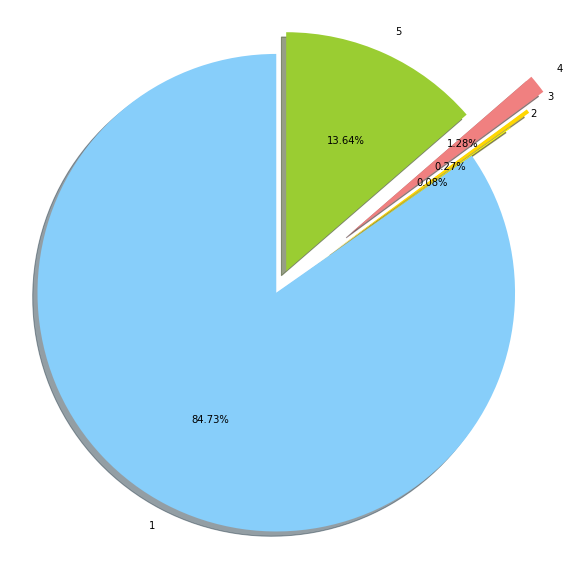

In [233]:
labels = ['1','2','3','4','5']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen']
explode = (0, 0.2, 0.3, 0.4, 0.1)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [276]:
cluster_df = pd.DataFrame(clusters)
cluster_df.index = portrait_df.index
frame = pd.concat([portrait_df, cluster_df], axis=1)

In [313]:
frame.head()

,recency,total_spent,avg_spent,med_spent,spent_range,quantities,varieties,frequency,valid_trans,refund,0
CustomerID,,,,,,,,,,,
0003B311-AEFF-494D-9AAD-9951FA5AC599,169,16554.28,88.054681,46.775,1677.05,217,160,188,184.0,1.0,3
0005861F-87C4-4CEB-80D4-61CFB8F34E47,173,3458.70,111.570968,76.000,340.00,33,30,31,31.0,0.0,0
000684B2-425D-4B3E-9F97-388B88C2A2AD,155,11432.30,178.629688,101.500,856.00,139,54,64,61.0,0.0,0
000728AC-3ED5-479A-8DF9-3A94AA40665F,140,61919.39,154.798475,75.000,2286.50,527,252,400,400.0,0.0,0
0008248F-CEAB-407C-9626-73283BB11EB4,148,4196.78,209.839000,79.550,1632.00,30,20,20,20.0,0.0,0


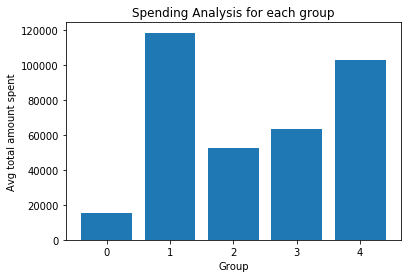

In [322]:
plt.bar(range(5),list(frame.groupby(0).total_spent.mean()), )
plt.title("Spending Analysis for each group")
plt.xlabel("Group")
plt.ylabel("Avg total amount spent")
plt.gcf()
plt.show()

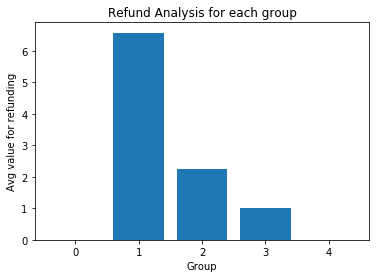

In [321]:
plt.bar(range(5),list(frame.groupby(0).refund.mean()), )
plt.title("Refund Analysis for each group")
plt.xlabel("Group")
plt.ylabel("Avg value for refunding")
plt.gcf()
plt.show()

### We can hence name each group (roughly) based on such analysis

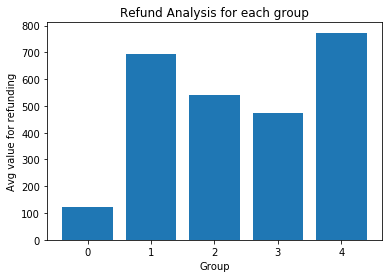

In [323]:
plt.bar(range(5),list(frame.groupby(0).frequency.mean()), )
plt.title("Refund Analysis for each group")
plt.xlabel("Group")
plt.ylabel("Avg value for refunding")
plt.gcf()
plt.show()

### such as from this analysis, we understand that the group 0 is very special -- call it common?